In [1]:
#| default_exp datasets

In [2]:
# TODO: get rid of this dirty hack
import os
os.getcwd()
import sys
sys.path.append("/Users/htkumar/fastai_course")

In [3]:
#| export
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

from fastai_course.training import *

('a', 'd', 'g')


In [4]:
fit?

Signature: fit(epochs, model, loss_func, opt, train_dl, valid_dl)
Docstring: <no docstring>
File:      ~/fastai_course/fastai_course/training.py
Type:      function

In [6]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path
from torch import tensor, nn, optim
from torch.utils.data import DataLoader

import torch.nn.functional as F
from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [7]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [8]:
logging.disable(logging.WARNING)

### Hugging Face datasets

In [9]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)

In [12]:
# load_dataset_builder??

In [13]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [14]:
ds_builder.info.description

"Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of\n60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,\nassociated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in\nreplacement for the original MNIST dataset for benchmarking machine learning algorithms.\nIt shares the same image size and structure of training and testing splits.\n"

In [15]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [16]:
dsd = load_dataset(name)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /Users/htkumar/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [19]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [20]:
train,test = dsd['train'],dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [21]:
x,y = 'image', 'label'
img = train[0][x]
img

In [22]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [23]:
y

'label'

In [25]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [26]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [27]:
yb

[9, 0, 0, 3, 0]

In [34]:
type(xb[0])

PIL.PngImagePlugin.PngImageFile

In [28]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [31]:
TF.to_tensor??

Signature: TF.to_tensor(pic) -> torch.Tensor
Source:   
def to_tensor(pic) -> Tensor:
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.

    See :class:`~torchvision.transforms.ToTensor` for more details.

    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.

    Returns:
        Tensor: Converted image.
    """
    if not torch.jit.is_scripting() and not torch.jit.is_tracing():
        _log_api_usage_once(to_tensor)
    if not (F_pil._is_pil_image(pic) or _is_numpy(pic)):
        raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")

    if _is_numpy(pic) and not _is_numpy_image(pic):
        raise ValueError(f"pic should be 2/3 dimensional. Got {pic.ndim} dimensions.")

    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_nump

In [35]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [36]:
test

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [37]:
len(train)

60000

In [38]:
train[1]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 0}

In [39]:
featy?

Signature:   featy()
Type:        ClassLabel
String form: ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)
File:        ~/anaconda3/lib/python3.10/site-packages/datasets/features/features.py
Docstring:  
Feature type for integer class labels.

There are 3 ways to define a `ClassLabel`, which correspond to the 3 arguments:

 * `num_classes`: Create 0 to (num_classes-1) labels.
 * `names`: List of label strings.
 * `names_file`: File containing the list of labels.

Under the hood the labels are stored as integers.
You can use negative integers to represent unknown/missing labels.

Args:
    num_classes (`int`, *optional*):
        Number of classes. All labels must be < `num_classes`.
    names (`list` of `str`, *optional*):
        String names for the integer classes.
        The order in which the names are provided is kept.
    names_file (`str`, *optional*):
        Path to a file with names for

In [40]:
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [41]:
def collate_fn(b):
    return {
        x: torch.stack([TF.to_tensor(o[x]) for o in b]),
        y: tensor([o[y] for o in b])
    }

In [42]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)

In [44]:
b = next(iter(dl))
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [47]:
TF.to_tensor(train[0][x]).shape

torch.Size([1, 28, 28])

In [48]:
train

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [55]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [56]:
len(train)

60000

In [58]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [60]:
#| export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [61]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [63]:
tdsf = train.with_transform(transformi)

In [65]:
tdsf[0][x].shape, tdsf[0][y]

(torch.Size([784]), 9)

In [66]:
d = dict(a=1, b=2, c=3)
ig = itemgetter('a', 'c')
ig(d)

(1, 3)

In [67]:
class D:
    def __getitem__(self, k):
        return 1 if k == "a" else 2 if k == 'b' else 3

In [68]:
d = D()
ig(d)

(1, 3)

In [70]:
list(tdsf.features)

['image', 'label']

In [75]:
type(tdsf[0])

dict

In [100]:
batch = dict(a=[1], b=[2]), dict(a=[2], b=[3]), dict(a=[2], b=[3])
default_collate(batch)

{'a': [tensor([1, 2, 2])], 'b': [tensor([2, 3, 3])]}

In [73]:
list(tdsf.features)

['image', 'label']

In [93]:
#| export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): 
        # print(type(b[0]))
        return get(default_collate(b))
    return _f

In [94]:
dlf = DataLoader(tdsf, collate_fn=collate_dict(tdsf), batch_size=4)

In [95]:
i = next(iter(dlf))

In [99]:
i[0].shape, i[1].shape

(torch.Size([4, 784]), torch.Size([4]))

In [103]:
tdsf[0]['image'].shape

torch.Size([784])

In [105]:
# default_collate??

In [115]:
def f(*args, **kwargs):
    print(args)
    print(kwargs)

In [116]:
f(1, 2, c=1,d=1)

(1, 2)
{'c': 1, 'd': 1}


In [117]:
f = lambda a,b: a + b

In [119]:
f(1, 2)

3

In [120]:
from functools import partial

In [121]:
g = partial(f, 1)

In [122]:
g(2)

3

In [124]:
# g??

### Plotting images

In [132]:
b = next(iter(dl))
xb = b[x]
xb.shape

torch.Size([16, 1, 28, 28])

In [133]:
img = xb[0]
img.shape

torch.Size([1, 28, 28])

In [135]:
img[0].shape

torch.Size([28, 28])

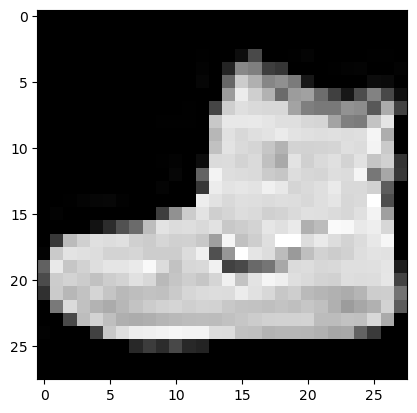

In [136]:
plt.imshow(img[0])

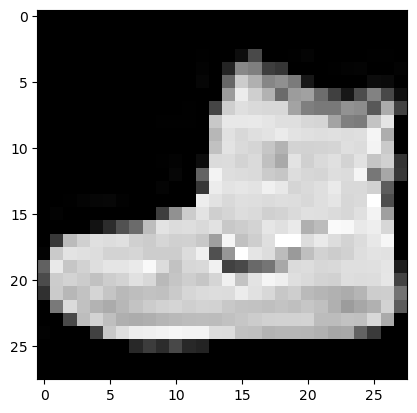

In [137]:
plt.imshow(img.squeeze())

In [138]:
fc.hasattrs??

Signature: fc.hasattrs(o, attrs)
Source:   
def hasattrs(o,attrs):
    "Test whether `o` contains all `attrs`"
    return all(hasattr(o,attr) for attr in attrs)
File:      ~/anaconda3/lib/python3.10/site-packages/fastcore/basics.py
Type:      function

In [141]:
tensor.detach??

Object `tensor.detach` not found.


In [142]:
a = torch.randn(1, 28, 28)

In [143]:
a.permute(1, 2, 0).shape

torch.Size([28, 28, 1])

In [146]:
a.permute(1, 2, 0)[...,0].shape

torch.Size([28, 28])

In [148]:
#| export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noFrames=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`"

    if fc.hasattrs(im, ('cpu', 'detach', 'permute')):
        im = im.detach().cpu()
        if len(im.shape) == 3 and im.shape[0] < 5: im = im.permute(1, 2, 0)
    
    elif not isinstance(im,np.ndarray): im = np.array(im)
    if im.shape[-1] == 1: im = im[...,0]

    if ax is None:
        _,ax = plt.subplots(figsize=figsize)
    
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noFrames: ax.axis('off')
    return ax

In [153]:
# plt.subplots??

In [154]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noFrames=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`



<Axes: >

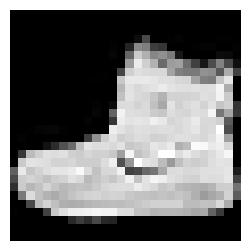

In [156]:
show_image(img, figsize=(3,3))

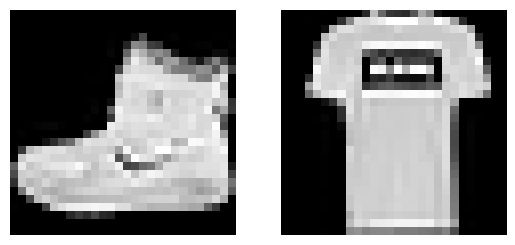

In [158]:
fig, axs = plt.subplots(1, 2)
show_image(xb[0], axs[0])
show_image(xb[1], axs[1]);

In [197]:
# fig, ax = plt.subplots(2, 2);
# ax.flat??

In [164]:
#| export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rowss in returned axes grid
    ncols:int=1, # Number of cols in returned axes grid
    figsize:tuple=None, # width, height in inches of returned figure
    imsize:int=3, # size of the image being displayed in inches
    suptitle: str = None, # Title to set
    **kwargs
): # fig and axes
    "A figure and set of plots to display the images"
    if figsize is None: figsize = (ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows * ncols==1: ax = np.array([ax])
    return fig, ax


In [166]:
from nbdev.showdoc import show_doc

In [167]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

A figure and set of plots to display the images

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rowss in returned axes grid |
| ncols | int | 1 | Number of cols in returned axes grid |
| figsize | tuple | None | width, height in inches of returned figure |
| imsize | int | 3 | size of the image being displayed in inches |
| suptitle | str | None | Title to set |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

In [169]:
help(subplots)

Help on function subplots in module __main__:

subplots(nrows: 'int' = 1, ncols: 'int' = 1, figsize: 'tuple' = None, imsize: 'int' = 3, suptitle: 'str' = None, *, sharex=False, sharey=False, squeeze=True, width_ratios=None, height_ratios=None, subplot_kw=None, gridspec_kw=None, **kwargs)
    A figure and set of plots to display the images



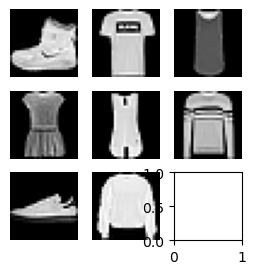

In [170]:
fig, axs = subplots(3,3,imsize=1)
imgs = xb[:8]
for i, j in zip(axs.flat, imgs):
    show_image(j,i)

In [181]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

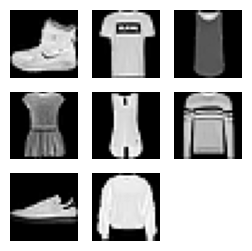

In [183]:
fig, axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat, imgs):
    show_image(img, ax)

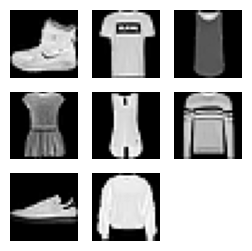

In [187]:
fig, axs = get_grid(8, ncols=3, imsize=1)
for ax,img in zip(axs.flat, imgs):
    show_image(img, ax)

In [186]:
np.ceil(1.3), np.floor(2.9)

(2.0, 2.0)

In [190]:
def f() -> list | bool:
    return True

In [191]:
f()

True

In [198]:
a = [[1,2,3], [4, 5, 6]]
# a.flat

In [199]:
zip_longest??

Init signature: zip_longest(self, /, *args, **kwargs)
Docstring:     
zip_longest(iter1 [,iter2 [...]], [fillvalue=None]) --> zip_longest object

Return a zip_longest object whose .__next__() method returns a tuple where
the i-th element comes from the i-th iterable argument.  The .__next__()
method continues until the longest iterable in the argument sequence
is exhausted and then it raises StopIteration.  When the shorter iterables
are exhausted, the fillvalue is substituted in their place.  The fillvalue
defaults to None or can be specified by a keyword argument.
Type:           type
Subclasses:     

In [201]:
#| export
@fc.delegates(subplots)
def show_images(ims:list, nrows:int|None=None, ncols:int|None=None, titles:list|None=None, **kwargs):
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for ax, t, img in zip_longest(axs, titles or [], ims):
        show_image(img, ax=ax, title=t)

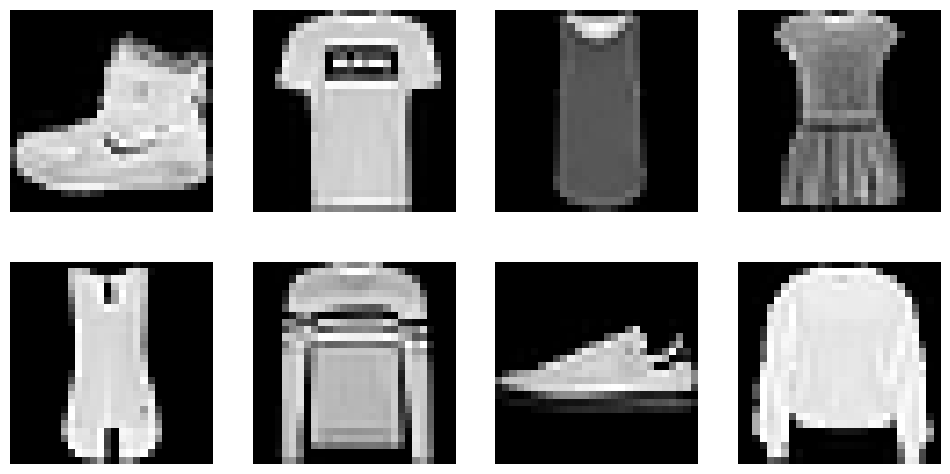

In [204]:
show_images(xb[:8])

In [212]:
yb = b[y]
lbls = yb[:8]
lbls

tensor([9, 0, 0, 3, 0, 2, 7, 2])

In [213]:
# itemgetter??

In [214]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
names

['Top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Boot']

In [217]:
titles = itemgetter(*lbls)(names)
titles

('Boot', 'Top', 'Top', 'Dress', 'Top', 'Pullover', 'Sneaker', 'Pullover')

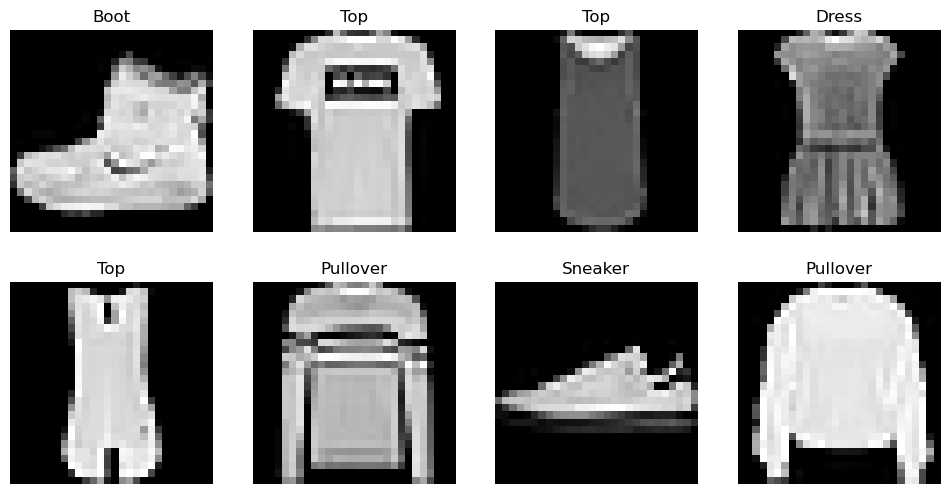

In [221]:
show_images(imgs, titles=titles)

In [222]:
collate_dict??

Signature: collate_dict(ds)
Docstring: <no docstring>
Source:   
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): 
        # print(type(b[0]))
        return get(default_collate(b))
    return _f
File:      /var/folders/c8/mt_y_mg14_s14_slht8ds95w0000gn/T/ipykernel_35115/3943869593.py
Type:      function

In [223]:
default_collate??

Signature: default_collate(batch)
Source:   
def default_collate(batch):
    r"""
        Function that takes in a batch of data and puts the elements within the batch
        into a tensor with an additional outer dimension - batch size. The exact output type can be
        a :class:`torch.Tensor`, a `Sequence` of :class:`torch.Tensor`, a
        Collection of :class:`torch.Tensor`, or left unchanged, depending on the input type.
        This is used as the default function for collation when
        `batch_size` or `batch_sampler` is defined in :class:`~torch.utils.data.DataLoader`.

        Here is the general input type (based on the type of the element within the batch) to output type mapping:

            * :class:`torch.Tensor` -> :class:`torch.Tensor` (with an added outer dimension batch size)
            * NumPy Arrays -> :class:`torch.Tensor`
            * `float` -> :class:`torch.Tensor`
            * `int` -> :class:`torch.Tensor`
            * `str` -> `str` (unchanged)
  

In [224]:
import nbdev; nbdev.nbdev_export()

In [1]:
from typing import Any


class B:
    a,b = 1,2
    # def __getattr__(self, k):
    #     if k[0] == '_':
    #         return AttributeError(k)
    #     return f"Hello from {k}"
    
    def __getattribute__(self, __name: str):
        return f"Hello from {__name}"

In [2]:
b = B()

In [3]:
b.a

'Hello from a'

In [4]:
getattr(b, 'a')

'Hello from a'